### Informacje dotyczące pomiarów:

* Pomiary czasu dla funkcji odwracania uwzględniają czasy działania algorytmu mnożenia macierzy (tutaj Binet)
* Pomiary czasu dla funckji eliminacji Gaussowskiej uwzględniają czasy działania algorytmów odwracania macierzy i mnożenia macierzy
* W ramach zliczania operacji zmiennoprzecnikowych zliczano operacje na macierzach
* Pliki .csv zawierające pomiary egzekucji algorytmów na maszynie z procesorem i5 13-400f będą nazywane <nazwa_algorytmu>_results_i5_13400f.csv

### Przygotowanie importów do przetworzenia wyników:

Poniższą komórkę wystarczy uruchomić jeden raz.

In [1]:
using Pkg
Pkg.add("CSV")
Pkg.add("DataFrames")
Pkg.add("Plots")
Pkg.add("LinearAlgebra")
Pkg.add("LaTeXStrings")
Pkg.add("StatsPlots");

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`


To z kolei proszę uruchomić każdorazowo przed egzekucją kodu niżej w pliku.

In [2]:
using CSV
using DataFrames
using Plots
using LinearAlgebra
using LaTeXStrings
using StatsPlots;

### Konfiguracja

In [3]:
# number generation range
low, high = 0.00000001, 1.0

# name of the CPU - will be appended to the results filename
cpu_name = "M1_Pro"

# number of exmaples
start_n, end_n = 3, 200;

##### Algorytm do porównywania identyczności macierzy:

In [4]:
function are_equal(A, B, error_eps=1e-6)
    if !all(size(A) .== size(B))
        return false
    end
    
    return all(abs.(A-B) .< error_eps)
end;

##### Algorytm do generowania macierzy o losowych elementach:

In [5]:
function generate_random_matrix(m,n,a,b)
    A = zeros(m,n)
    for i in 1:m 
        for j in 1:n
            A[i,j] = a + (b-a)*rand()
        end
    end
    return A
end;

### zmienne globalne

In [6]:
additions, multiplications = 0, 0;

Implementacja funkcji Binet'a (pisana w ramch poprzedniego laboratorium), która posłuży do rekurencyjnego mnożenia macierzy.

Zdecydowano się na użycie tej funkcji ze względu na fakt, że jej wydajność czasowa nie ulega znacznym pogorszeniom przy zwiększaniu krawędzi macierzy z wartości $2^n$ do $2^{n+1}$, gdzie $n$ to dowolna liczba naturalna, oraz fakt, że Binet'em można w miarę prosty sposób mnożyć macierze, które się kwadratowe i różnią się dokładnymi kształtami.

In [7]:
function binet(A, B)
    global additions, multiplications
    m, n, p = size(A)[1], size(A)[2], size(B)[2]

    if m == 1 && n == 1 && p == 1
        multiplications += 1
        return reshape([A[1,1] * B[1,1]], 1, 1)
    elseif m > 1 && n > 1 && p > 1
        floor_m, floor_n, floor_p = div(m, 2), div(n, 2), div(p, 2)

        A_11 = A[1:floor_m, 1:floor_n]
        A_12 = A[1:floor_m, floor_n+1:end]
        A_21 = A[floor_m+1:end, 1:floor_n]        
        A_22 = A[floor_m+1:end, floor_n+1:end]
        B_11 = B[1:floor_n, 1:floor_p]
        B_12 = B[1:floor_n, floor_p+1:end]
        B_21 = B[floor_n+1:end, 1:floor_p]
        B_22 = B[floor_n+1:end, floor_p+1:end]

        upper = [binet(A_11, B_11) + binet(A_12, B_21) binet(A_11, B_12) + binet(A_12, B_22)]
        lower = [binet(A_21, B_11) + binet(A_22, B_21) binet(A_21, B_12) + binet(A_22, B_22)]

        additions += m * p

        return [upper ; lower]
    elseif m == 1 && n > 1 && p > 1
        floor_n, floor_p = div(n, 2), div(p, 2)

        A_11 = A[1:end , 1:floor_n]
        A_12 = A[1:end , floor_n+1:end]
        B_11 = B[1:floor_n , 1:floor_p]
        B_12 = B[1:floor_n , floor_p+1:end]
        B_21 = B[floor_n+1:end , 1:floor_p]
        B_22 = B[floor_n+1:end , floor_p+1:end]

        additions += p

        return [binet(A_11,B_11) + binet(A_12,B_21) binet(A_11,B_12) + binet(A_12,B_22)]
    elseif m == 1 && n == 1 && p > 1
        floor_p = div(p, 2)

        B_11 = B[1:end , 1:floor_p]
        B_12 = B[1:end , floor_p+1:end]

        return [binet(A, B_11) binet(A, B_12)]
    elseif m == 1 && n > 1 && p == 1
        floor_n = div(n, 2)

        A_11 = A[1:end , 1:floor_n]
        A_12 = A[1:end , floor_n+1:end]
        B_11 = B[1:floor_n , 1:end]
        B_21 = B[floor_n+1:end , 1:end]

        additions += 1

        return binet(A_11, B_11) + binet(A_12, B_21)
    elseif m > 1 && n == 1 && p > 1
        floor_m, floor_p = div(m, 2), div(p, 2)

        A_11 = A[1:floor_m , 1:end]
        A_21 = A[floor_m+1:end , 1:end]
        B_11 = B[1:end , 1:floor_p ]
        B_12 = B[1:end , floor_p+1:end]   

        upper = [binet(A_11, B_11) binet(A_11, B_12)]
        lower = [binet(A_21, B_11) binet(A_21, B_12)]

        return [upper ; lower]
    elseif m > 1 && n == 1 && p == 1   
        floor_m = div(m,2)

        A_11 = A[1:floor_m , 1:end]
        A_21 = A[floor_m+1:end , 1:end]

        return [binet(A_11, B) ; binet(A_21, B)] 
    elseif m > 1 && n > 1 && p == 1
        floor_m, floor_n = div(m,2), div(n,2)

        A_11 = A[1:floor_m , 1:floor_n]
        A_12 = A[1:floor_m , floor_n+1:end]
        A_21 = A[floor_m+1:end , 1:floor_n]        
        A_22 = A[floor_m+1:end , floor_n+1:end]
        B_11 = B[1:floor_n , 1:end]
        B_21 = B[floor_n+1:end , 1:end]

        additions += m

        return [binet(A_11,B_11) + binet(A_12,B_21) ; binet(A_21,B_11) + binet(A_22,B_21)]    
    end
end;

### Rekurencyjny algorytm odwracania macierzy:

Wzór na rekurencyjnę odwracania macierzy można zapisać następująco:

$$ A^{-1} = \begin{bmatrix} B_{11} & B_{12} \\ B_{21} & B_{22} \end{bmatrix} $$

gdzie:

$$ A = \begin{bmatrix} A_{11} & A_{12} \\ A_{21} & A_{22} \end{bmatrix} $$

oraz:

$$ \text{1: } S_{22} = A_{22} - A_{21} A_{11}^{-1} A_{12} $$
$$ \text{2: } B_{11} = A_{11}^{-1} (I + A_{12} S_{22}^{-1} A_{21} A_{11}^{-1}) $$
$$ \text{3: } B_{12} = -A_{11}^{-1} A_{12} S_{22}^{-1} $$
$$ \text{4: } B_{21} = -S_{22}^{-1} A_{21} A_{11}^{-1} $$
$$ \text{5: } B_{22} = S_{22}^{-1} $$

gdzie $ I $ jest (kwadratową) macierzą identyczności (1 na głównej przekątnej, reszta 0).

Należy zaznaczyć, że podział macierzy A na podmacierze ma pewne ograniczenia wynikające ze wzorów 1-4 i definicji odwracalności macierzy. Mając na uwadzę te ograniczenia należy pokazać jaki podział na podmacierze jest dozwolony. 

Nawias (x,y) w dolnym indeksie oznacza, że macierz ma x wierszy i y kolumn.

$$ A_{11} = A_{11 (b,c)} $$
$$ A_{12} = A_{12 (d,e)} $$
$$ A_{21} = A_{21 (f,g)} $$
$$ A_{22} = A_{22 (h,i)} $$

W poniższych przekształceniach używano własności już udowodnionych w linjkach wyżej bez explicite pisania tego za każdym razem.

Z definicji odwracalności macierzy $ A_{11} $: $ \text{ } b = c $

Ze wzoru 1: $ \text{ } A_{21 (f,g)} A_{11 (b,b)}^{-1} A_{12 (d,e)} \text{ jest wykonywalne } (=\Omega _{(f,e)}) \text{ } \implies g = b \land b = d $ 

Ze wzoru 1 i powyższego: $ \text{ } A_{22 (h,i)} - \Omega _ {(f,e)} \text { jest wykonywalne } \implies h = f \land i = e $

Z własności odwracalności macierzy $ S_{22 (f,e)} $ : $ \text{ } h = i \land f = e $ 

Ze wzoru 2: $ \text{ } B_{11} = A_{11 (b,b)}^{-1} (I_{(b,b)} + A_{12 (b,e)} S_{22 (e,e)}^{-1} A_{21 (e,b)} A_{11 (b,b)}^{-1}) \implies B_{11} = B_{11 (b,b)} $

Ze wzoru 3: $ \text{ } B_{12} = -A_{11 (b,b)}^{-1} A_{12 (b,e)} S_{22 {e,e}}^{-1} \implies B_{12} = B_{12 (b,e)} $

Ze wzoru 4: $ \text{ } B_{21} = -S_{22 (e,e)}^{-1} A_{21 (e,b)} A_{11 (b,b)}^{-1} \implies B_{21} = B_{21 (e,b)} $

Ze wzoru 5: $ \text{ } B_{22} = S_{22}^{-1} \implies B_{22} = B_{22 (e,e)} $

Powyższe wyprowadzanie pozwalają wysnuć wnioski na temat rozmiarów podmacierzy A, co jest bardzo ważne z punktu widzenia implementacji:

$$ A_{11} = A_{11 (b,b)} $$
$$ A_{12} = A_{12 (b,e)} $$
$$ A_{21} = A_{21 (e,b)} $$
$$ A_{22} = A_{22 (e,e)} $$

Biorąc pod uwagę, że $ b+e = n $ dla $ A_{(n,n)} $ przyjmujemy, że $ b = \lfloor \frac{n}{2} \rfloor $ oraz $ e = n-b $.

##### Kod algorytmu rekurencyjnego odwracania macierzy:

In [8]:
function inverse(A, matmul)
    global additions, multiplications

    n, m = size(A)
    if (n != m) 
        error("Something went wrong, you can only invert square matrixes")
    end

    if (n == 1)
        return reshape([A[1, 1] ^ (-1)], 1, 1)
    end

    b = div(n,2)

    A_11 = A[1:b , 1:b]
    A_12 = A[1:b , b+1:end]
    A_21 = A[b+1:end , 1:b]
    A_22 = A[b+1:end , b+1:end]

    A_11_inv = inverse(A_11, matmul)
    F = matmul(A_21, A_11_inv)

    H = matmul(F, A_12)
    S_22 = A_22 - H

    S_22_inv = inverse(S_22, matmul)
    G = matmul(A_12, S_22_inv)

    J = matmul(G,F)

    B_11 = matmul(A_11_inv, Matrix{Float64}(I, b, b) + J)

    K = matmul(A_11_inv, G)
    B_12 = -K       

    L = matmul(S_22_inv, F)
    B_21 = -L
    
    B_22 = S_22_inv

    additions += size(H)[1] * size(H)[2] + size(J)[1] * size(J)[2]

    return [B_11 B_12 ; B_21 B_22]
end

inverse (generic function with 1 method)

Jeżli wyników testowania funkcji rekurencyjnej nie ma w pliku .csv, należy uruchomić poniższy kod:

In [9]:
function test_matrix_inversion(start_n, end_n, a, b, matmul)
    global additions, multiplications

    results = DataFrame(n = Int[], correct = Bool[], additions = Int[], multiplications = Int[], time = Float64[])

    for n in start_n:1:end_n
        additions, multiplications = 0, 0
        A = generate_random_matrix(n, n, a, b)

        tik = time()
        results_matrix = inverse(A, matmul)
        tok = time()

        correct = are_equal(results_matrix, inv(A))

        push!(results, (n, correct, additions, multiplications, tok - tik))
    end

    return results
end;

In [10]:
filename = "inverse_results_$cpu_name.csv"

if !isfile(filename)
    df = test_matrix_inversion(start_n, end_n, low, high, binet)
    CSV.write(filename, df);
end

"inverse_results_M1_Pro.csv"

Jeżeli wyniki są w pliku należy je wczytać i wyświetlić przy użyciu poniższego kodu:

In [11]:
inv_df = CSV.read(filename, DataFrame)

Row,n,correct,additions,multiplications,time
,Int64,Bool,Int64,Int64,Float64
1,3,true,12,26,0.508721
2,4,true,40,70,5.07832e-5
3,5,true,84,131,3.00407e-5
4,6,true,168,241,4.50611e-5
5,7,true,274,375,6.19888e-5
6,8,true,448,588,8.89301e-5
7,9,true,632,805,0.000124931
8,10,true,918,1137,0.000175953
9,11,true,1222,1487,0.000228167


##### Wykres czasu egzekucji algorytmu:

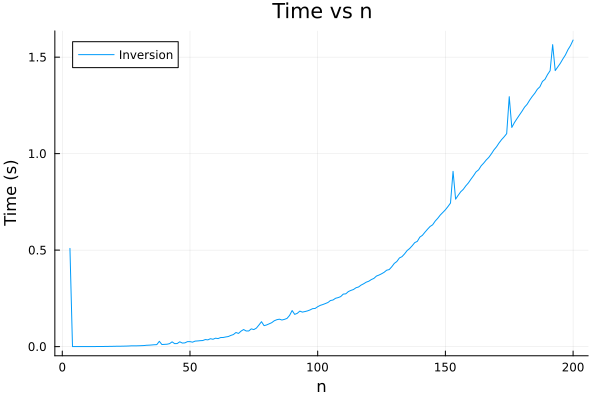

In [12]:
plot(inv_df.n, inv_df.time, label="Inversion", xlabel="n", ylabel="Time (s)", title="Time vs n")

##### Wykres liczby operacji:

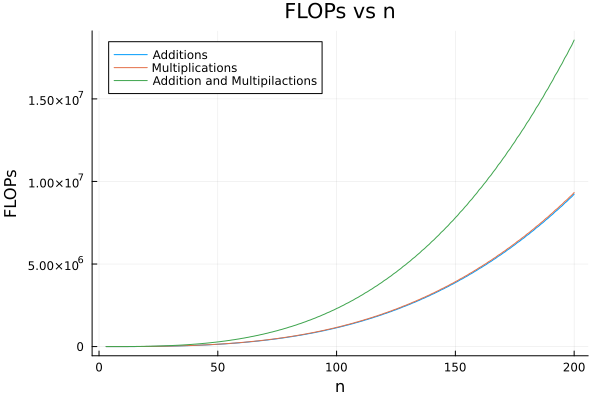

In [13]:
plot(inv_df.n,   inv_df.additions, label="Additions",  xlabel="n", ylabel="FLOPs", title="FLOPs vs n")
plot!(inv_df.n,  inv_df.multiplications, label="Multiplications")
plot!(inv_df.n, inv_df.additions + inv_df.multiplications, label="Addition and Multipilactions",)

### Rekurenycjny algorytm faktoryzacji LU:

Problem faktoryzacji LU jest często przedstawiany w następujący sposób:

$$ A = LU $$

gdzie:

$$ A = \begin{bmatrix} A_{11} & A_{12} \\ A_{21} & A_{22} \end{bmatrix} $$

$$ L = \begin{bmatrix} L_{11} & 0 \\ L_{21} & L_{22} \end{bmatrix} $$

$$ U = \begin{bmatrix} U_{11} & U_{12} \\ 0 & U_{22} \end{bmatrix} $$

gdzie przez 0 w powyższych wzorach rozumiemy macierz wypełnioną 0.

Z uwagi na definicję faktoryzacji należy zaznaczyć, że macierz A musi być macierzą kwadratową, a zarówno L, jak i U muszą mieć takie same kształty co A.

Wprowadzamy również zapis funkcji faktoryzacji zwracającej macierze L oraz U:

$$ [L, U] = LU_{fact}(A) $$

Po wymnożeniu macierzy L i U otrzymujemy:

$$ LU = \begin{bmatrix} L_{11} U_{11} & L_{11} U_{12} \\ L_{21} U_{11} & L_{21} U_{12} + L_{22} U_{22} \end{bmatrix} $$

Przyrównajmy podmacierze z macierzy wynikowej do podmacierzy macierzy A:

$$ \text{I: } A_{11} = L_{11} U_{11} $$

$$ \text{II: } A_{12} = L_{11} U_{12} $$

$$ \text{III: } A_{21} = L_{21} U_{11} $$

$$ \text{IV: } A_{22} = L_{21} U_{12} + L_{22} U_{22} $$

Znalezienie podmacierzy L i U odbywa się następująco:

$$ \text{1: } [L_{11}, U_{11}] = LU_{fact}(A_{11}) $$

$$ \text{2: Mnożenie obustronne I przez } L_{11}^{-1} \text{ (lewostronne): } L_{11}^{-1} A_{11} = L_{11}^{-1} L_{11} U_{11} \implies U_{11} = L_{11}^{-1} A_{11} $$

$$ \text{3: Mnożenie obustronne II przez } L_{11}^{-1} \text{ (lewostronne): } L_{11}^{-1} A_{12} = L_{11}^{-1} L_{11} U_{12} \implies U_{12} = L_{11}^{-1} A_{12} $$

$$ \text{4: Mnożenie obustronne III przez } U_{11}^{-1} \text{ (prawostronne): } A_{21} U_{11}^{-1} = L_{21} U_{11} U_{11}^{-1} \implies L_{21} = A_{21} U_{11}^{-1} $$

$$ \text{5: Odjęcie obustrone } L_{21} U_{12} \text{ w IV: } L_{22} U_{22} = A_{22} - L_{21} U_{12} \implies L_{22} U_{22} = A_{22} - A_{21} U_{11}^{-1} L_{11}^{-1} A_{12} $$ 

$$ \text{6: } [L_{22}, U_{22}] = LU_{fact}(L_{22} U_{22}) $$

Mając na uwadze punkty I-IV, 1-6 oraz własności problemów faktoryzacji LU, jak i inwersji macierzy ustalamy jakie kształty powinny mieć podmacierze A, L oraz U:

Tymczasowo zapiszmy:

$$ A_{11} = A_{11 (b,c)} $$
$$ A_{12} = A_{12 (d,e)} $$
$$ A_{21} = A_{21 (f,g)} $$
$$ A_{22} = A_{22 (h,i)} $$

Ze wzoru 1 oraz własności faktoryzacji LU: $ A_{11 (b,c)} = A_{11 (b,b)} $

Ze wzoru 1 oraz własności faktoryzacji LU: $ L_{11} = L_{11 (b,b)} \land U_{11} = U_{11 (b,b)} $

Ze wzoru 3 oraz własności inwersji macierzy: $ U_{12} = L_{11 (b,b)}^{-1} A_{12 (d,e)} \implies d=b \land U_{12} = U_{12 (b,e)} $

Ze wzoru 4 oraz własności inwersji macierzy: $ L_{21} = A_{21 (f,g)} U_{11 (b,b)}^{-1} \implies g=b \land L_{21} = L_{21 (f,b)} $

Ze wzoru 5: $ A_{22 (h,i)} A_{21 (f,b)} U_{11 (b,b)}^{-1} L_{11 (b,b)}^{-1} A_{12 (b,e)} \implies h=f \land i=e $

Ze wzoru 5: $ L_{22} U_{22} = (L_{22} U_{22})_{(f,e)} $

Ze wzoru 6 i własności faktoryzacji LU: $ L_{22} = L_{22 (f,e)} \land U_{22} = U_{22 (f,e)} \land f=e $

Podsumowując powyższe wyprowadzenia:

$$ b=c=d=g \land e=f=h=i $$

Wiedząc już jak należy podzielić macierz A przy wykonywaniu na niej faktoryzacji LU można już przystąpić do implementacji. Dokładne wartości $ b $ oraz $ e $ mogą być dowolne, o ile $ b+e=n $ (gdzie $ n $ to rozmiar krawędzi macierzy), przy implementacji (podobnie jak w przypadku odwracania macierzy) przymujemy, że $ b = \lfloor \frac{n}{2} \rfloor $ oraz $ e = n-b $.

##### Kod faktoryzacji LU:

In [14]:
function LU_fact(A, matmul)
    global additions, multiplications

    m = size(A)[1]
    n = size(A)[2]

    if (m != n)
        error("Something went wrong, can only LU factorize square matrixes")
    end

    if n == 1
        return A, reshape([1], 1, 1)
    end

    b = div(n,2)
    A_11 = A[1:b , 1:b]
    A_12 = A[1:b , b+1:end]
    A_21 = A[b+1:end , 1:b]
    A_22 = A[b+1:end , b+1:end]
    
    L_11, U_11 = LU_fact(A_11, matmul)
    L_11_inv = inverse(L_11, matmul)
    U_11_inv = inverse(U_11, matmul)
    L_21 = matmul(A_21, U_11_inv)
    U_12 = matmul(L_11_inv, A_12)
    P = matmul(L_21, U_12)

    S = A_22 - P

    L_22, U_22 = LU_fact(S, matmul)

    additions = size(P)[1] * size(P)[2]

    return [L_11 zeros(b,n-b) ; L_21 L_22], [U_11 U_12 ; zeros(n-b,b) U_22]
end

LU_fact (generic function with 1 method)

Jeżeli wyniki testowania algorytmu LU nie znajdując się w odpowiednim pliku .csv należy uruchomić poniższy kod:

In [15]:
function test_LU_fact(start_n, end_n, a, b, matmul)
    global additions, multiplications

    results = DataFrame(n = Int[], correct = Bool[], additions = Int[], multiplications = Int[], time = Float64[])

    for n in start_n:end_n
        additions, multiplications  = 0, 0
        A = generate_random_matrix(n, n, a, b)

        tik = time()
        result_L, result_U = LU_fact(A, matmul)
        tok = time()

        correct = are_equal(result_L * result_U, A)

        push!(results, (n, correct, additions, multiplications, tok - tik))
    end
    
    return results
end;

In [16]:
filename = "lu_fact_results_$cpu_name.csv"

if !isfile(filename)
    df = test_LU_fact(start_n, end_n, low, high, binet)
    CSV.write(filename, df);
end

"lu_fact_results_M1_Pro.csv"

Jeżeli wyniki są już w pliku .csv wystarczy załadować i wyświetlić wyniki:

In [17]:
lu_df = CSV.read(filename, DataFrame)

Row,n,correct,additions,multiplications,time
,Int64,Bool,Int64,Int64,Float64
1,3,true,4,11,0.176941
2,4,true,4,44,0.00010705
3,5,true,9,70,4.79221e-5
4,6,true,9,155,7.08103e-5
5,7,true,16,227,7.89165e-5
6,8,true,16,420,0.000110865
7,9,true,25,514,0.000129938
8,10,true,25,777,0.000180006
9,11,true,36,967,0.000217915


##### Wykres czasu egzekucji algorytmu:

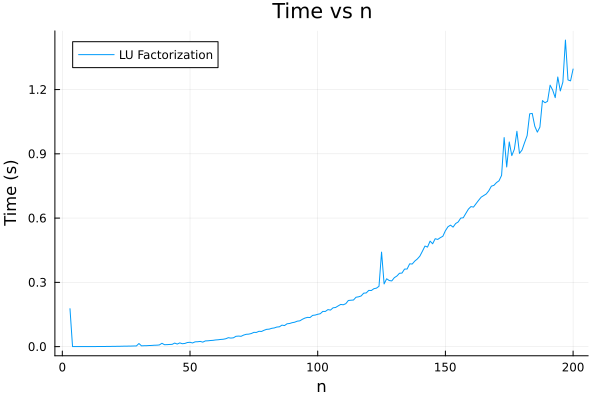

In [18]:
plot(lu_df.n, lu_df.time, label="LU Factorization", xlabel="n", ylabel="Time (s)", title="Time vs n")

##### Wykres liczby operacji:

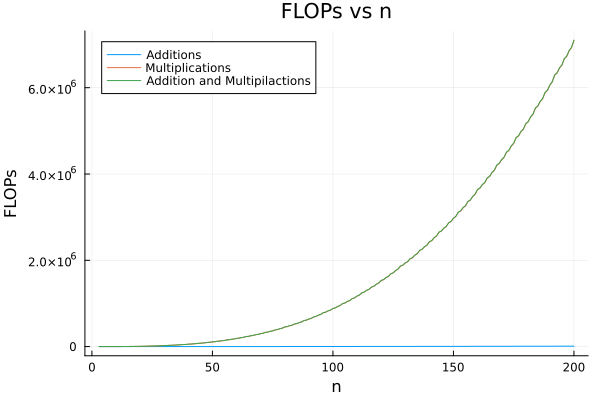

In [19]:
plot(lu_df.n,   lu_df.additions, label="Additions",  xlabel="n", ylabel="FLOPs", title="FLOPs vs n")
plot!(lu_df.n,  lu_df.multiplications, label="Multiplications")
plot!(lu_df.n, lu_df.additions + lu_df.multiplications, label="Addition and Multipilactions",)

### Eliminacja Gaussa


$$ \begin{bmatrix} A_{11} & A_{12} \\ A_{21} & A_{22} \end{bmatrix} * \begin{bmatrix} x_{1} \\ x_{2} \end{bmatrix} =\begin{bmatrix} b_{1} \\ b_{2} \end{bmatrix} $$

$$ \begin{bmatrix} C_{11} & C_{12} \\ C_{21} & C_{22} \end{bmatrix} * \begin{bmatrix} x_{1} \\ x_{2} \end{bmatrix} = \begin{bmatrix} U_{11} & L_{11}^{-1}A_{12} \\ 0 & U_{S} \end{bmatrix} * \begin{bmatrix} x_{1} \\ x_{2} \end{bmatrix} = \begin{bmatrix} L_{11}^{-1}b_{1} \\ L_{S}^{-1}b_{2} - L_{S}^{-1}A_{21}U{11}^{-1}L_{11}^{-1}b{1} \end{bmatrix} = \begin{bmatrix} RHS_{1} \\ RHS_{2} \end{bmatrix}$$

gdzie:
- $ \begin{bmatrix} L_{11} & U_{11} \end{bmatrix} = LU(A_{11}) $
- $ L_{11}^{-1} = inverse(L_{11}) $
- $ U_{11}^{-1} = inverse(U_{11}) $
- $ S = A_{22} - A_{21}U_{11}^{-1}L_{11}^{-1}A_{12} $
- $ \begin{bmatrix} L_{S} & U_{S} \end{bmatrix} = LU(S) $
- $ C_{11} = U_{11}, C_{12} = L_{11}^{-1}A_{12}, C_{22} = U_{S} $
- $ RHS_{1} = L_{11}^{-1}b_{1} $
- $ RHS_{2} = L_{S}^{-1}b_{2} - L_{S}^{-1}A_{21}U_{11}^{-1}L_{11}^{-1}b_{1} $



In [20]:
function gaussian_elimination(A, b, matmul)
    global additions, multiplications

    A_m, A_n = div(size(A, 1), 2), div(size(A, 2), 2)

    A11, A12, A21, A22 = A[1:A_m, 1:A_n], A[1:A_m, A_n+1:end], A[A_m+1:end, 1:A_n], A[A_m+1:end, A_n+1:end]

    L11, U11 = LU_fact(A11, matmul)
    L11_inv = inverse(L11, matmul)
    U11_inv = inverse(U11, matmul)
    S = A22 - matmul(matmul(A21, U11_inv), matmul(L11_inv, A12))
    LS, US = LU_fact(S, matmul)
    LS_inv = inverse(LS, matmul)
    C = zeros(size(A))
    C[1:A_m, 1:A_n] = U11
    C[1:A_m, A_n+1:end] = matmul(L11_inv, A12)
    C[A_m+1:end, A_n+1:end] = US

    RHS = zeros(size(b))
    RHS[1:A_m] = L11_inv * b[1:A_m] #TODO
    LS_inv_A21 = matmul(LS_inv, A21)
    U11_inv_RHS1 = U11_inv * RHS[1:A_m] #TODO
    RHS[A_m+1:end] = LS_inv * b[A_m+1:end] - LS_inv_A21 * U11_inv_RHS1 #TODO

    additions += size(S)[1] * size(S)[2] + size(RHS[A_m+1:end])[1]
    multiplications += size(L11_inv)[1] * size(L11_inv)[2] + size(U11_inv)[1] * size(U11_inv)[2]
    multiplications += size(LS_inv)[1] * size(LS_inv)[2] + size(LS_inv_A21)[1] * size(LS_inv_A21)[2]
    
    return C, RHS
end

gaussian_elimination (generic function with 1 method)

In [21]:
function test_gaussian_elimination(start_n, end_n, low, high, matmul)
    global additions, multiplications

    results = DataFrame(n = Int[], correct = Bool[], additions = Int[], multiplications = Int[], time = Float64[])

    for n in start_n:end_n
        additions, multiplications = 0, 0

        A = generate_random_matrix(n, n, low, high)
        X = generate_random_matrix(n, 1, low, high)
        B = A*X

        tik = time()
        C, RHS = gaussian_elimination(A, B, matmul)
        tok = time()

        test1 = are_equal(inv(C) * RHS, X, max(minimum(abs.(X)) / 1000, 1e-4))
        test2 = are_equal(C*X, RHS, max(minimum(abs.(RHS)) / 1000, 1e-4))
        correct = test1 & test2

        push!(results, (n, correct, additions, multiplications, tok - tik))
    end

    return results
end;

In [22]:
filename = "gaussian_elimination_results_$cpu_name.csv"

if !isfile(filename)
    df = test_gaussian_elimination(start_n, end_n, low, high, binet)
    CSV.write(filename, df);
end

"gaussian_elimination_results_M1_Pro.csv"

In [23]:
gaussian_elimination_df = CSV.read(filename, DataFrame)

Row,n,correct,additions,multiplications,time
,Int64,Bool,Int64,Int64,Float64
1,3,true,11,32,0.161368
2,4,true,17,83,0.000104189
3,5,true,46,149,6.38962e-5
4,6,true,64,271,8.70228e-5
5,7,true,124,427,0.000111818
6,8,true,160,682,0.000147104
7,9,true,263,902,0.00019002
8,10,true,323,1258,0.000254869
9,11,true,489,1654,0.000324965


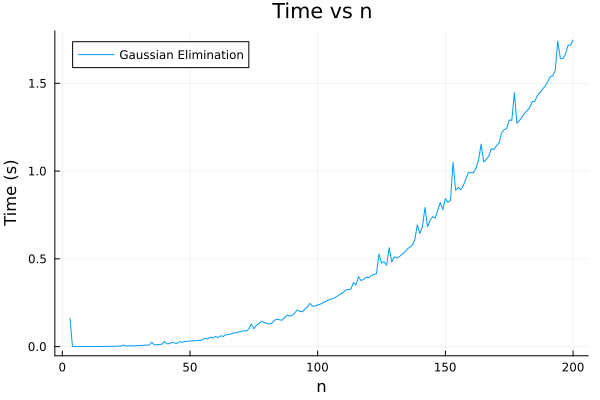

In [24]:
plot(gaussian_elimination_df.n, gaussian_elimination_df.time, label="Gaussian Elimination", xlabel="n", ylabel="Time (s)", title="Time vs n")

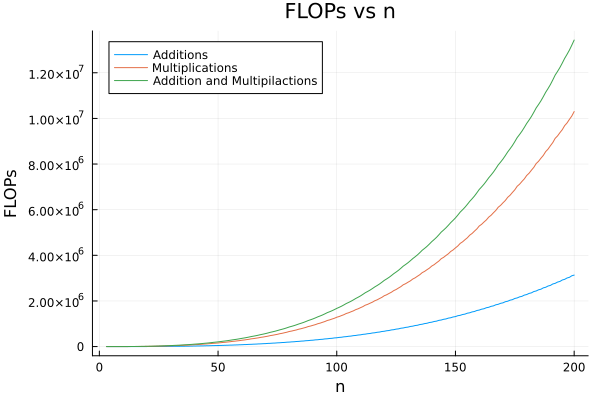

In [25]:
plot(gaussian_elimination_df.n,   gaussian_elimination_df.additions, label="Additions",  xlabel="n", ylabel="FLOPs", title="FLOPs vs n")
plot!(gaussian_elimination_df.n,  gaussian_elimination_df.multiplications, label="Multiplications")
plot!(gaussian_elimination_df.n, gaussian_elimination_df.additions + gaussian_elimination_df.multiplications, label="Addition and Multipilactions",)

### Wyznacznik Macierzy

$$ \text{det}(A) = l_{11} * ... * l_{nn} * u_{11} * ... * u_{nn} $$

gdzie:
- $ l_{ii} $ to przekątna macierzy L
- $ u_{ii} $ to przekątna U

In [26]:
function determinant(A, matmul)
    global additions, multiplications
    
    m, n = size(A)
    if m != n
        error("The matrix must be square to calculate the determinant")
    end

    L, U = LU_fact(A, matmul)

    determinant_value = 1

    for i in 1:n
        determinant_value *= L[i,i] * U[i,i]
        multiplications += 1
    end

    return determinant_value
end;

In [27]:
function test_determinant(start_n, end_n, low, high, matmul)
    global additions, multiplications
    
    results = DataFrame(n = Int[],  determinant = Float64[], correct = Bool[], additions = Int[], multiplications = Int[], time = Float64[])

    for n in start_n:end_n
        additions, multiplications = 0, 0

        A = generate_random_matrix(n, n, low, high)

        tik = time()
        determinant_value = determinant(A, matmul)
        tok = time()
        
        correct = are_equal(determinant_value, det(A), abs(det(A)) / 1000)

        push!(results, (n, determinant_value, correct, additions, multiplications, tok - tik))
    end

    return results
end;

In [28]:
filename = "determinant_results_$cpu_name.csv"

if !isfile(filename)
    df = test_determinant(start_n, end_n, low, high, binet)
    CSV.write(filename, df);
end

"determinant_results_M1_Pro.csv"

In [29]:
determinant_df = CSV.read(filename, DataFrame)

Row,n,determinant,correct,additions,multiplications,time
,Int64,Float64,Bool,Int64,Int64,Float64
1,3,-0.300733,true,4,14,8.79765e-5
2,4,-0.0914182,true,4,48,9.89437e-5
3,5,0.00064219,true,9,75,4.41074e-5
4,6,-0.0346801,true,9,161,6.79493e-5
5,7,-0.0317163,true,16,234,7.98702e-5
6,8,0.0248732,true,16,428,0.000119925
7,9,0.0132345,true,25,523,0.000132084
8,10,0.0128591,true,25,787,0.000182152
9,11,0.00293019,true,36,978,0.000219107


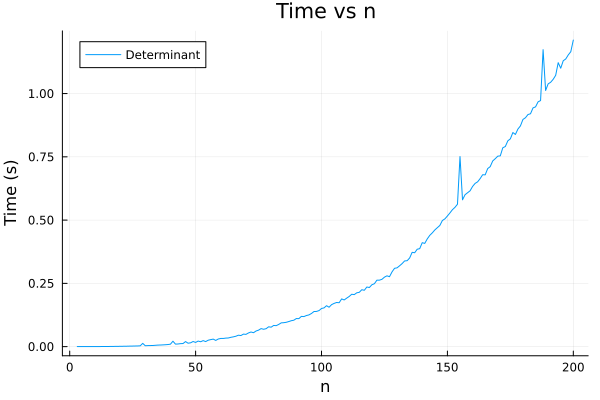

In [30]:
plot(determinant_df.n, determinant_df.time, label="Determinant", xlabel="n", ylabel="Time (s)", title="Time vs n")

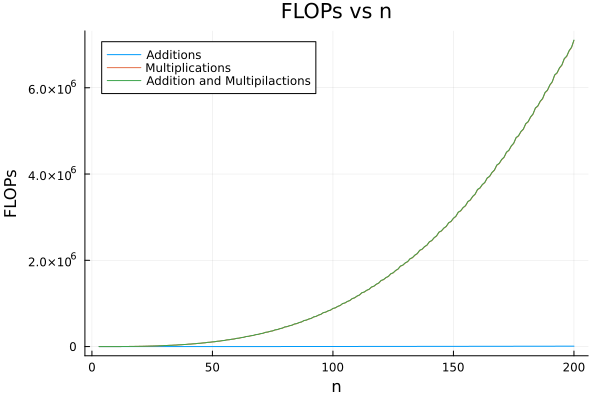

In [31]:
plot(determinant_df.n,   determinant_df.additions, label="Additions",  xlabel="n", ylabel="FLOPs", title="FLOPs vs n")
plot!(determinant_df.n,  determinant_df.multiplications, label="Multiplications")
plot!(determinant_df.n, determinant_df.additions + determinant_df.multiplications, label="Addition and Multipilactions",)

# Złożoność obliczeniowa algorytmów:

Bazując na wykresach czasu egzekucji algorytmów oraz liczb operacji, można dojść do wniosku, że złożoności algorytmów odwracania macierzy oraz faktoryzacji są w bardzo dużej mierze zależne od użytego algorytmu mnożenia macierzy. Użyty wyżej algorytm Binet'a ma złożność ~$ O(n^{3}) $, co dość dobrze widać na wykresach:

##### Dla algorytmu odwracania macierzy:

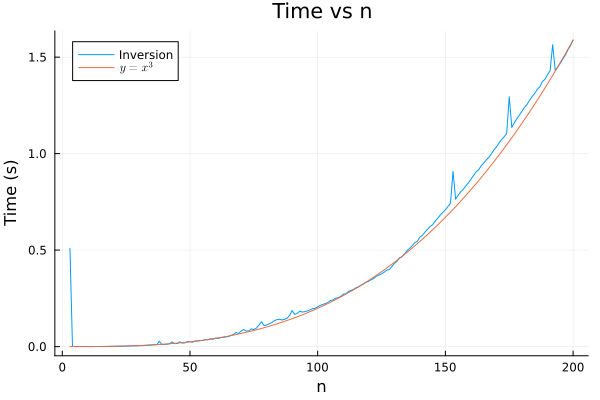

In [32]:
plot(inv_df.n, inv_df.time, label="Inversion", xlabel="n", ylabel="Time (s)", title="Time vs n")
coef = inv_df[end, :time] / (end_n^3)
plot!(inv_df.n, x->coef*(x^3), label=L"$y=x^{3}$")

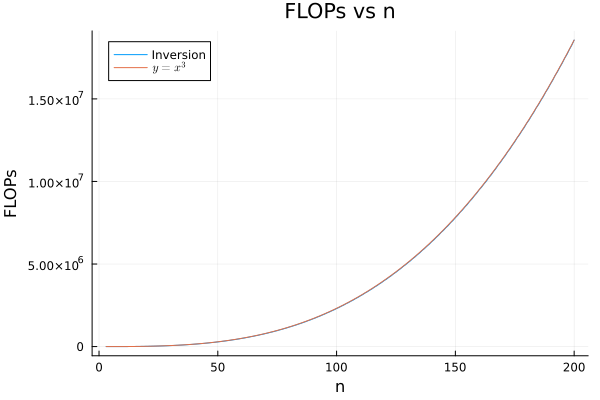

In [33]:
plot(inv_df.n, inv_df.additions + inv_df.multiplications, label="Inversion", xlabel="n", ylabel="FLOPs", title="FLOPs vs n")
coef = (inv_df[end, :additions]+inv_df[end, :multiplications]) / (end_n^3)
plot!(inv_df.n, x->coef*(x^3), label=L"$y=x^{3}$")

##### Dla algorytmu faktoryzacji LU:

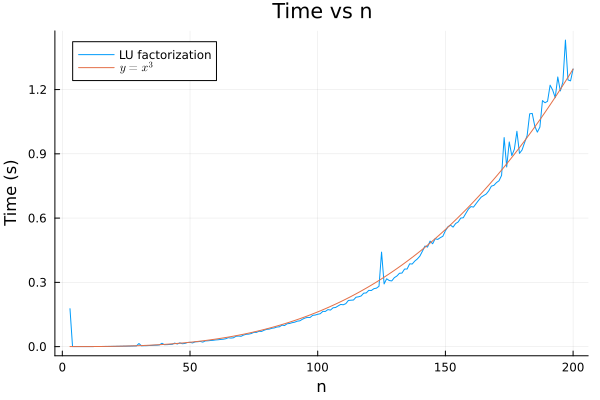

In [34]:
plot(lu_df.n, lu_df.time, label="LU factorization", xlabel="n", ylabel="Time (s)", title="Time vs n")
coef = lu_df[end, :time] / (end_n^3)
plot!(lu_df.n, x->coef*(x^3), label=L"$y=x^{3}$")

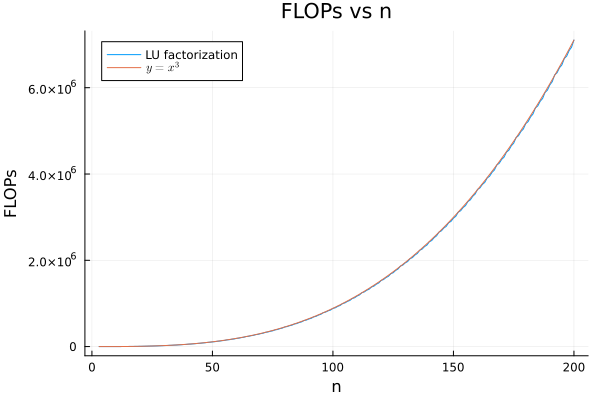

In [35]:
plot(lu_df.n, lu_df.additions + lu_df.multiplications, label="LU factorization", xlabel="n", ylabel="FLOPs", title="FLOPs vs n")
coef = (lu_df[end, :additions]+lu_df[end, :multiplications]) / (end_n^3)
plot!(lu_df.n, x->coef*(x^3), label=L"$y=x^{3}$")

##### Dla eliminacji Gaussa:

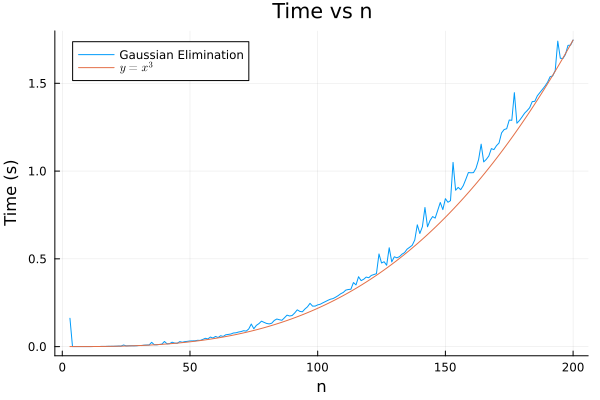

In [36]:
plot(gaussian_elimination_df.n, gaussian_elimination_df.time, label="Gaussian Elimination", xlabel="n", ylabel="Time (s)", title="Time vs n")
coef = gaussian_elimination_df[end, :time] / (end_n^3)
plot!(gaussian_elimination_df.n, x->coef*(x^3), label=L"$y=x^{3}$")

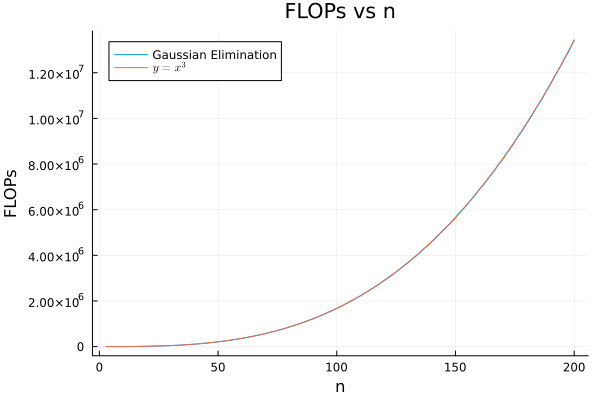

In [37]:
plot(gaussian_elimination_df.n, gaussian_elimination_df.additions + gaussian_elimination_df.multiplications, label="Gaussian Elimination", xlabel="n", ylabel="FLOPs", title="FLOPs vs n")
coef = (gaussian_elimination_df[end, :additions]+gaussian_elimination_df[end, :multiplications]) / (end_n^3)
plot!(gaussian_elimination_df.n, x->coef*(x^3), label=L"$y=x^{3}$")

##### Dla algorytmu liczenia wyznacznika:

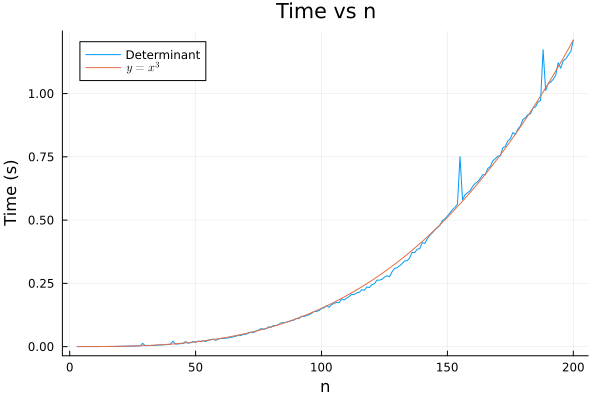

In [38]:
plot(determinant_df.n, determinant_df.time, label="Determinant", xlabel="n", ylabel="Time (s)", title="Time vs n")
coef = determinant_df[end, :time] / (end_n^3)
plot!(determinant_df.n, x->coef*(x^3), label=L"$y=x^{3}$")

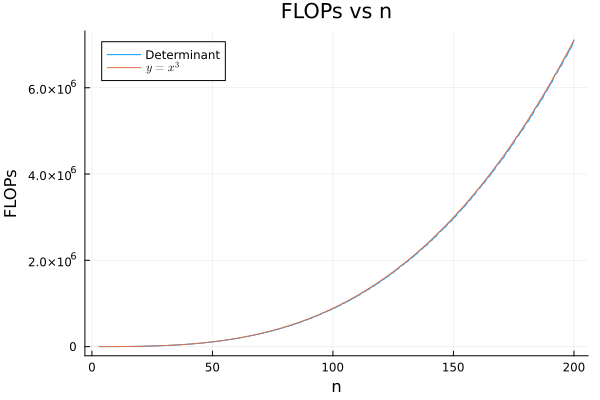

In [39]:
plot(determinant_df.n, determinant_df.additions + determinant_df.multiplications, label="Determinant", xlabel="n", ylabel="FLOPs", title="FLOPs vs n")
coef = (determinant_df[end, :additions]+determinant_df[end, :multiplications]) / (end_n^3)
plot!(determinant_df.n, x->coef*(x^3), label=L"$y=x^{3}$")

Aby być pewniejszym tezy przedstawionej na początku sekcji warto sprawdzić jak zmieni się złożność w przypadku użyciu algorytmu Strassen'a zamiast algorytmu Binet'a do mnożenia macierzy. Algorytm Strassen'a ma złożoność ~$O(7^{\lceil log_{2}n \rceil})$, więc odpowiednio powinny zmienić się czasy działań i liczby operacji na macierzach algorytmów.

In [40]:
function strassen(A, B)
    global additions, multiplications

    if size(A, 1) == 1 && size(B, 2) == 1
        multiplications += 1
        return A * B
    end

    A_m, B_n = size(A, 1), size(B, 2)

    pad = max(size(A, 1), size(A, 2), size(B, 1), size(B, 2))
    if pad % 2 != 0
        pad += 1
    end

    A_padded = zeros(eltype(A), pad, pad)
    B_padded = zeros(eltype(B), pad, pad)

    A_padded[1:size(A, 1), 1:size(A, 2)] = A
    B_padded[1:size(B, 1), 1:size(B, 2)] = B

    m = div(pad, 2)

    A11, A12 = A_padded[1:m, 1:m], A_padded[1:m, m+1:end]
    A21, A22 = A_padded[m+1:end, 1:m], A_padded[m+1:end, m+1:end]

    B11, B12 = B_padded[1:m, 1:m], B_padded[1:m, m+1:end]
    B21, B22 = B_padded[m+1:end, 1:m], B_padded[m+1:end, m+1:end]

    additions += 18 * m * m

    A11pA22 = A11 + A22
    B11pB22 = B11 + B22
    A21pA22 = A21 + A22
    B12mB22 = B12 - B22
    B21mB11 = B21 - B11
    A11pA12 = A11 + A12
    A21mA11 = A21 - A11
    B11pB12 = B11 + B12
    A12mA22 = A12 - A22
    B21pB22 = B21 + B22

    P1 = strassen(A11pA22, B11pB22)
    P2 = strassen(A21pA22, B11)
    P3 = strassen(A11, B12mB22)
    P4 = strassen(A22, B21mB11)
    P5 = strassen(A11pA12, B22)
    P6 = strassen(A21mA11, B11pB12)
    P7 = strassen(A12mA22, B21pB22)

    C = zeros(eltype(A), pad, pad)

    C[1:m, 1:m] = P1 + P4 - P5 + P7
    C[1:m, m+1:end] = P3 + P5
    C[m+1:end, 1:m] = P2 + P4
    C[m+1:end, m+1:end] = P1 - P2 + P3 + P6

    return C[1:A_m, 1:B_n]
end

strassen (generic function with 1 method)

In [41]:
filename = "inverse_results_strassen_$cpu_name.csv"

if !isfile(filename)
    inv_df_s = DataFrame(test_matrix_inversion(start_n, end_n, low, high, strassen), ["n", "correct", "additions", "multiplications", "time"]);
    inv_df_s.n = Int.(inv_df_s.n)
    inv_df_s.additions = Int.(inv_df_s.additions)
    inv_df_s.multiplications = Int.(inv_df_s.multiplications)
    CSV.write(filename, inv_df_s);
end

"inverse_results_strassen_M1_Pro.csv"

In [42]:
inv_df_s = CSV.read(filename, DataFrame)

Row,n,correct,additions,multiplications,time
,Int64,Bool,Int64,Int64,Float64
1,3,true,97,44,0.235057
2,4,true,138,63,1.69277e-5
3,5,true,1318,352,9.48906e-5
4,6,true,1598,431,0.000108004
5,7,true,1646,450,0.000108004
6,8,true,1694,469,0.000123024
7,9,true,10983,2522,0.000658035
8,10,true,13522,3105,0.000889063
9,11,true,13813,3184,0.000915051


In [43]:
filename = "lu_fact_results_strassen_$cpu_name.csv"

if !isfile(filename)
    lu_df_s = DataFrame(test_LU_fact(start_n, end_n, low, high, strassen), ["n", "correct", "additions", "multiplications", "time"]);

    lu_df_s.n = Int.(lu_df_s.n)
    lu_df_s.additions = Int.(lu_df_s.additions)
    lu_df_s.multiplications = Int.(lu_df_s.multiplications)
    CSV.write(filename, lu_df_s);
end

"lu_fact_results_strassen_M1_Pro.csv"

In [44]:
lu_df_s = CSV.read(filename, DataFrame)

Row,n,correct,additions,multiplications,time
,Int64,Bool,Int64,Int64,Float64
1,3,true,4,24,1.38684
2,4,true,4,41,1.81198e-5
3,5,true,9,188,5.48363e-5
4,6,true,9,283,7.60555e-5
5,7,true,16,300,7.70092e-5
6,8,true,16,355,9.799e-5
7,9,true,25,1384,0.000375032
8,10,true,25,2109,0.000540972
9,11,true,36,2204,0.000551939


In [45]:
filename = "gaussian_elimination_results_strassen_$cpu_name.csv"

if !isfile(filename)
    df = test_gaussian_elimination(start_n, end_n, low, high, strassen)
    CSV.write(filename, df);
end

"gaussian_elimination_results_strassen_M1_Pro.csv"

In [46]:
gaussian_elimination_df_s = CSV.read(filename, DataFrame)

Row,n,correct,additions,multiplications,time
,Int64,Bool,Int64,Int64,Float64
1,3,true,45,53,0.066117
2,4,true,45,78,2.09808e-5
3,5,true,509,353,0.000105143
4,6,true,509,461,0.000128031
5,7,true,558,507,0.000123024
6,8,true,558,580,0.000134945
7,9,true,4453,2499,0.000669003
8,10,true,4453,3247,0.000818014
9,11,true,4745,3437,0.000869989


In [47]:
filename = "determinant_results_strassen_$cpu_name.csv"

if !isfile(filename)
    df = test_determinant(start_n, end_n, low, high, strassen)
    CSV.write(filename, df);
end

"determinant_results_strassen_M1_Pro.csv"

In [48]:
determinant_df_s = CSV.read(filename, DataFrame)

Row,n,determinant,correct,additions,multiplications,time
,Int64,Float64,Bool,Int64,Int64,Float64
1,3,0.0137763,true,4,27,6.29425e-5
2,4,0.00022915,true,4,45,1.81198e-5
3,5,-0.137797,true,9,193,6.38962e-5
4,6,0.0527006,true,9,289,8.29697e-5
5,7,0.0612052,true,16,307,8.32081e-5
6,8,0.00401313,true,16,363,0.00685096
7,9,-0.00907427,true,25,1393,0.000368118
8,10,-0.0491564,true,25,2119,0.000608921
9,11,-0.0265324,true,36,2215,0.000637054


Sprawdźmy jak zmieniła się złożoność:

##### Dla algorytmu odwracania macierzy:

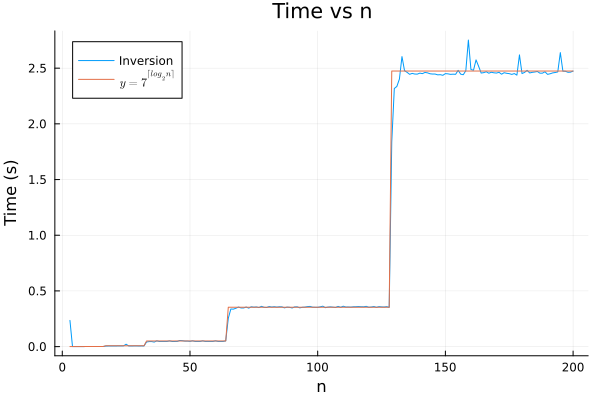

In [49]:
plot(inv_df_s.n, inv_df_s.time, label="Inversion", xlabel="n", ylabel="Time (s)", title="Time vs n")
coef = inv_df_s[end, :time] / (7^ceil(log2(end_n)))
plot!(inv_df_s.n, x->coef*(7^ceil(log2(x))), label=L"$y=7^{ \lceil log_{2}n \rceil }$")

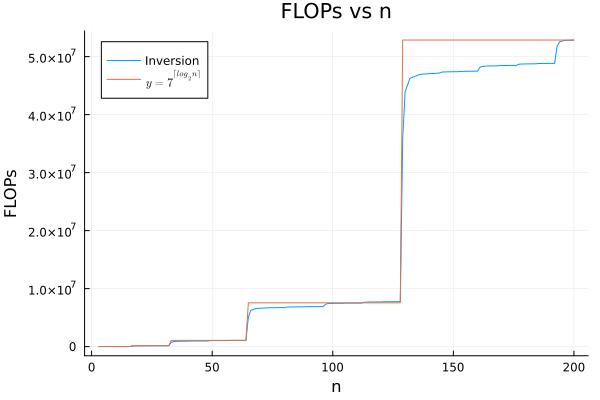

In [58]:
plot(inv_df_s.n, inv_df_s.additions + inv_df_s.multiplications, label="Inversion", xlabel="n", ylabel="FLOPs", title="FLOPs vs n")
coef = (inv_df_s[end, :additions]+inv_df_s[end, :multiplications]) / (7^ceil(log2(end_n)))
plot!(inv_df_s.n, x->coef*(7^ceil(log2(x))), label=L"$y=7^{ \lceil log_{2}n \rceil }$")

##### Dla algorytmu faktoryzacji LU:

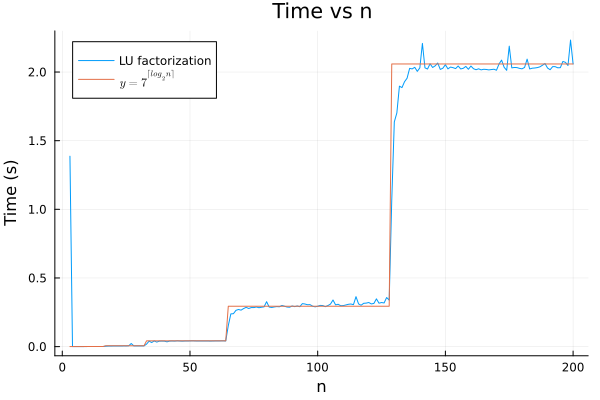

In [51]:
plot(lu_df_s.n, lu_df_s.time, label="LU factorization", xlabel="n", ylabel="Time (s)", title="Time vs n")
coef = lu_df_s[end, :time] / (7^ceil(log2(end_n)))
plot!(lu_df_s.n, x->coef*(7^ceil(log2(x))), label=L"$y=7^{ \lceil log_{2}n \rceil }$")

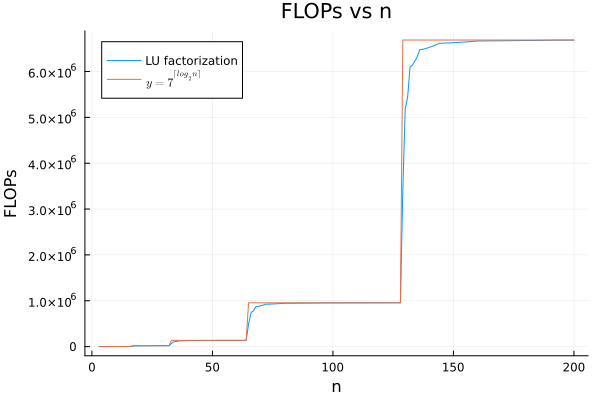

In [57]:
plot(lu_df_s.n, lu_df_s.additions + lu_df_s.multiplications, label="LU factorization", xlabel="n", ylabel="FLOPs", title="FLOPs vs n")
coef = (lu_df_s[end, :additions]+lu_df_s[end, :multiplications]) / (7^ceil(log2(end_n)))
plot!(lu_df_s.n, x->coef*(7^ceil(log2(x))), label=L"$y=7^{ \lceil log_{2}n \rceil }$")

##### Dla alogrytmu Eliminacji Gaussa:

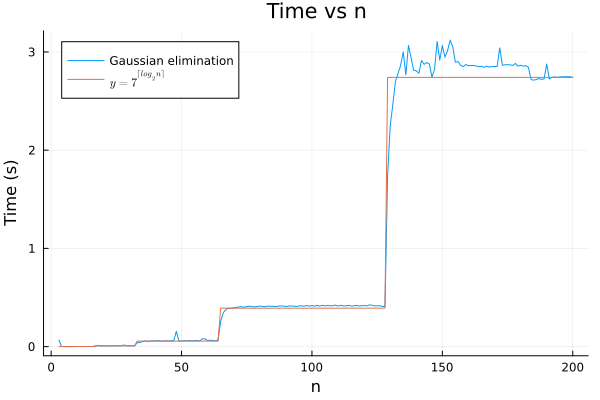

In [53]:
plot(gaussian_elimination_df_s.n, gaussian_elimination_df_s.time, label="Gaussian elimination", xlabel="n", ylabel="Time (s)", title="Time vs n")
coef = gaussian_elimination_df_s[end, :time] / (7^ceil(log2(end_n)))
plot!(gaussian_elimination_df_s.n, x->coef*(7^ceil(log2(x))), label=L"$y=7^{ \lceil log_{2}n \rceil }$")

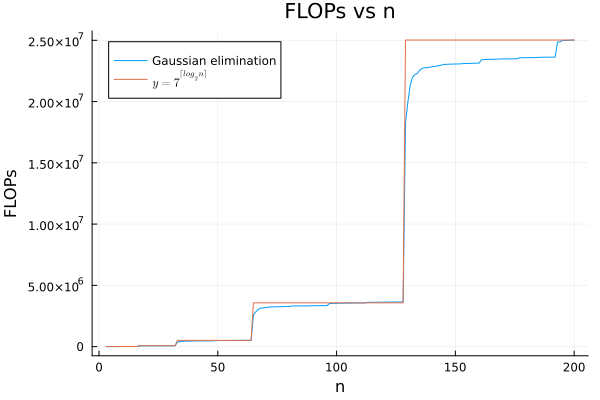

In [54]:
plot(gaussian_elimination_df_s.n, gaussian_elimination_df_s.additions + gaussian_elimination_df_s.multiplications, label="Gaussian elimination", xlabel="n", ylabel="FLOPs", title="FLOPs vs n")
coef = (gaussian_elimination_df_s[end, :additions]+gaussian_elimination_df_s[end, :multiplications]) / (7^ceil(log2(end_n)))
plot!(gaussian_elimination_df_s.n, x->coef*(7^ceil(log2(x))), label=L"$y=7^{ \lceil log_{2}n \rceil }$")

##### Dla algorytmu liczenia wyznacznika:

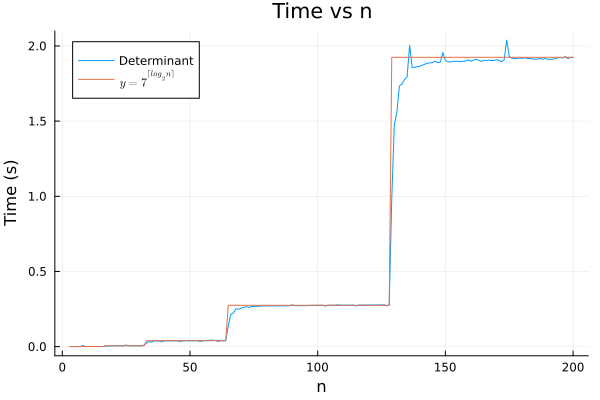

In [55]:
plot(determinant_df_s.n, determinant_df_s.time, label="Determinant", xlabel="n", ylabel="Time (s)", title="Time vs n")
coef = determinant_df_s[end, :time] / (7^ceil(log2(end_n)))
plot!(determinant_df_s.n, x->coef*(7^ceil(log2(x))), label=L"$y=7^{ \lceil log_{2}n \rceil }$")

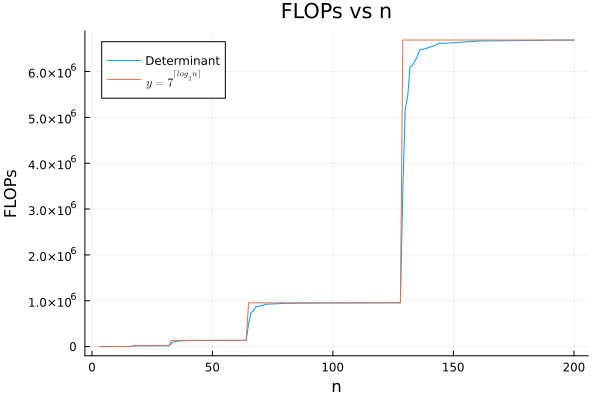

In [56]:
plot(determinant_df_s.n, determinant_df_s.additions + determinant_df_s.multiplications, label="Determinant", xlabel="n", ylabel="FLOPs", title="FLOPs vs n")
coef = (determinant_df_s[end, :additions] + determinant_df_s[end, :multiplications]) / (7^ceil(log2(end_n)))
plot!(determinant_df_s.n, x->coef*(7^ceil(log2(x))), label=L"$y=7^{ \lceil log_{2}n \rceil }$")

##### Wnioski na temat złożności obliczeniowej:

Jak widać po wykresach zamieszczonych w tej sekcji, złożność powyszych algorytmów jest ściśle związana z użytym algorytmem mnożenia macierzy. Przy użyciu algorytmu Binet'a złożoność była ~$ O(n^{3}) $, natomiast dla Strassena: ~$ O(7^{ \lceil log_{2}n \rceil }) $, a są to właśnie złożności wspomnianych algorytmów mnożenia.